## Task 1 - Data exploration and preparation

### 1.1 Exploration

--- TRAIN SET ---
Set: train, Class: paper, Image shape: (300, 300, 3)


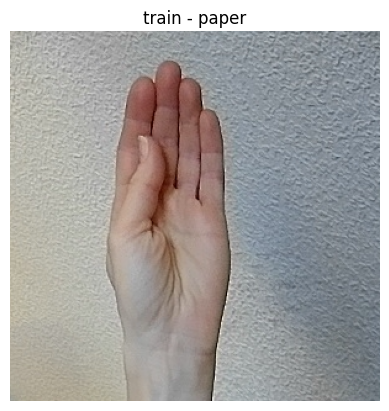

Set: train, Class: rock, Image shape: (300, 300, 3)


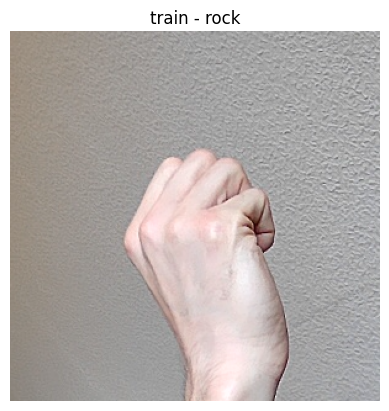

Set: train, Class: scissors, Image shape: (300, 300, 3)


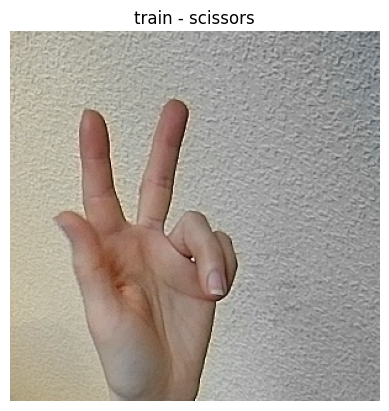

--- DEVTEST SET ---
Set: devtest, Class: rock, Image shape: (300, 300, 3)


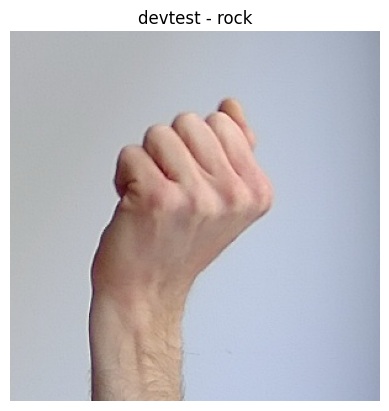

Set: devtest, Class: scissors, Image shape: (300, 300, 3)


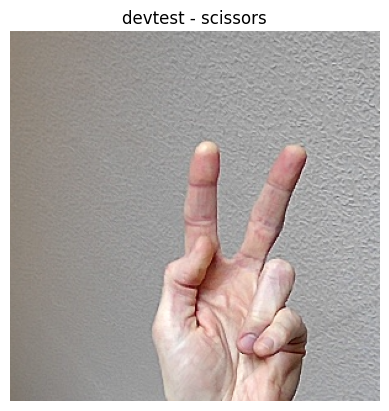

Set: devtest, Class: paper, Image shape: (300, 300, 3)


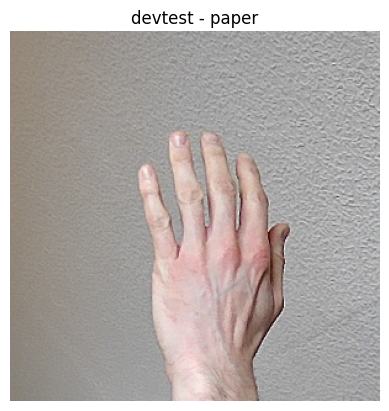

--- TEST SET ---
Set: test, Class: paper, Image shape: (300, 300, 3)


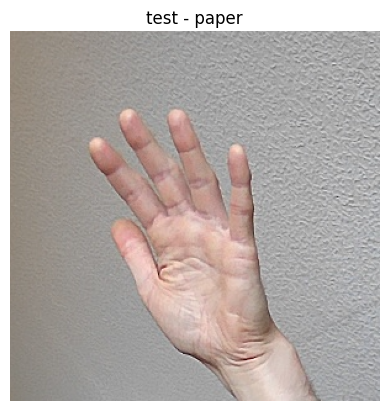

Set: test, Class: rock, Image shape: (300, 300, 3)


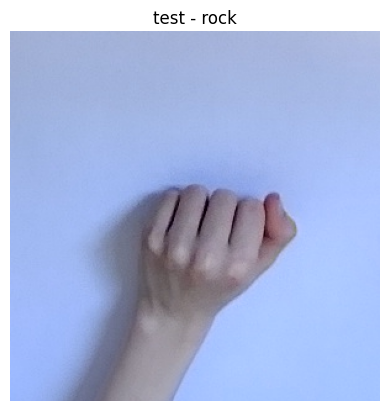

Set: test, Class: scissors, Image shape: (300, 300, 3)


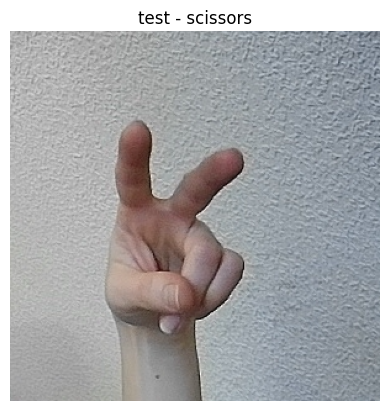


Class counts in TRAIN set:
  rock: 544
  paper: 544
  scissors: 541

Class counts in DEVTEST set:
  rock: 181
  paper: 181
  scissors: 180

Class counts in TEST set:
  rock: 182
  paper: 182
  scissors: 182


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
from collections import Counter

# Loaded CSV files
train_df = pd.read_csv('original_train.csv')
devtest_df = pd.read_csv('original_devtest.csv')
test_df = pd.read_csv('original_test.csv')

# Function to display one image per class from each set
def show_sample_images(df, set_name):
    print(f"--- {set_name.upper()} SET ---")
    shown_classes = set()
    for idx, row in df.iterrows():
        label = row['label']
        file_path = row['path']
        if label not in shown_classes:
            img = Image.open(file_path)
            img_array = np.array(img)
            print(f"Set: {set_name}, Class: {label}, Image shape: {img_array.shape}")
            plt.imshow(img)
            plt.title(f"{set_name} - {label}")
            plt.axis('off')
            plt.show()
            shown_classes.add(label)
        if len(shown_classes) == 3:
            break

# Show one image per class from each dataset
show_sample_images(train_df, 'train')
show_sample_images(devtest_df, 'devtest')
show_sample_images(test_df, 'test')

# Function to count images per class
def count_classes(df, set_name):
    counts = Counter(df['label'])
    print(f"\nClass counts in {set_name.upper()} set:")
    for cls in ['rock', 'paper', 'scissors']:
        print(f"  {cls}: {counts.get(cls, 0)}")

# Count class distribution in each set
count_classes(train_df, 'train')
count_classes(devtest_df, 'devtest')
count_classes(test_df, 'test')


### 1.2 Preparation

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Define image transformations: Resize + Normalize
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor()  # Converts to tensor and scales to [0, 1]
])

# Custom Dataset class using CSV and image folders
class RockPaperScissorsDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.label_map = {'rock': 0, 'paper': 1, 'scissors': 2}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['path']
        label = self.label_map[self.data.iloc[idx]['label']]
        image = Image.open(img_path).convert('RGB') 
        if self.transform:
            image = self.transform(image)
        return image, label

# Paths to CSV files
train_csv = 'original_train.csv'
devtest_csv = 'original_devtest.csv'
test_csv = 'original_test.csv'

# Create datasets
train_dataset = RockPaperScissorsDataset(train_csv, transform=transform)
devtest_dataset = RockPaperScissorsDataset(devtest_csv, transform=transform)
test_dataset = RockPaperScissorsDataset(test_csv, transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
devtest_loader = DataLoader(devtest_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


## Task 2 - Classification

### Task 2.1 Using ConvNets

### Defining the CNN model

In [4]:
import torch.nn as nn
import torch.nn.functional as F

# CNN using nn.Sequential
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),  # Output: (16, 100, 100)
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),  # Output: (16, 50, 50)

    nn.Conv2d(16, 32, kernel_size=3, padding=1),  # Output: (32, 50, 50)
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),  # Output: (32, 25, 25)

    nn.Flatten(),
    nn.Linear(32 * 25 * 25, 128),
    nn.ReLU(),
    nn.Linear(128, 3)  # 3 output classes
)


### Training the model

In [10]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
train_acc_history = []
devtest_acc_history = []

for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_acc = correct / total
    train_acc_history.append(train_acc)

    # Validation accuracy
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in devtest_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    devtest_acc = correct / total
    devtest_acc_history.append(devtest_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Acc: {train_acc:.4f}, DevTest Acc: {devtest_acc:.4f}")


Epoch 1/20, Train Acc: 0.3413, DevTest Acc: 0.4631
Epoch 2/20, Train Acc: 0.5414, DevTest Acc: 0.5959
Epoch 3/20, Train Acc: 0.6814, DevTest Acc: 0.6863
Epoch 4/20, Train Acc: 0.7581, DevTest Acc: 0.7620
Epoch 5/20, Train Acc: 0.7944, DevTest Acc: 0.8026
Epoch 6/20, Train Acc: 0.8478, DevTest Acc: 0.8210
Epoch 7/20, Train Acc: 0.8907, DevTest Acc: 0.8598
Epoch 8/20, Train Acc: 0.9147, DevTest Acc: 0.8985
Epoch 9/20, Train Acc: 0.9355, DevTest Acc: 0.8948
Epoch 10/20, Train Acc: 0.9435, DevTest Acc: 0.9114
Epoch 11/20, Train Acc: 0.9607, DevTest Acc: 0.8801
Epoch 12/20, Train Acc: 0.9619, DevTest Acc: 0.9410
Epoch 13/20, Train Acc: 0.9730, DevTest Acc: 0.9188
Epoch 14/20, Train Acc: 0.9693, DevTest Acc: 0.8745
Epoch 15/20, Train Acc: 0.9810, DevTest Acc: 0.9373
Epoch 16/20, Train Acc: 0.9908, DevTest Acc: 0.9576
Epoch 17/20, Train Acc: 0.9939, DevTest Acc: 0.9557
Epoch 18/20, Train Acc: 0.9975, DevTest Acc: 0.9539
Epoch 19/20, Train Acc: 0.9975, DevTest Acc: 0.9428
Epoch 20/20, Train Ac

### Plotting training vs devtest accuracy

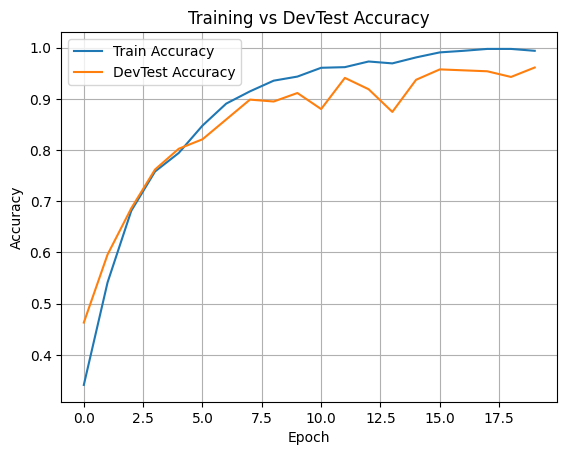

In [11]:
import matplotlib.pyplot as plt

plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(devtest_acc_history, label='DevTest Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs DevTest Accuracy')
plt.legend()
plt.grid(True)
plt.show()


### Testing accuracy after training ends

In [12]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Final Test Accuracy: {correct / total:.4f}")



Final Test Accuracy: 0.9634


##### To categorise rock-paper-scissors movements of the hands, a custom Convolutional Neural Network (ConvNet) was developed using PyTorch's nn.Sequential module. It consists of two convolutional layers followed by max pooling, ReLU activations, and fully connected layers.  The model's validation (DevTest) accuracy increased from 46% to roughly 96% after 20 training epochs, while its training accuracy steadily increased from 34% to almost 99%.  The depicted accuracy curves demonstrate that, up until about epoch 10, training and validation accuracy climb together. After that, training accuracy keeps increasing but validation accuracy starts to significantly fluctuate.  This points to a slight overfitting, in which the model becomes overly dependent on the training set. Despite this, the model generalizes well, achieving a final test accuracy of 96.34% on unseen data, indicating strong performance and effective learning from the dataset.

## Task 2.2 Using pre-trained models

### Importing and modyfing MobileNet

In [13]:
from torchvision import models
import torch.nn as nn

# Load pre-trained MobileNet
mobilenet = models.mobilenet_v2(pretrained=True)

# Freeze all layers
for param in mobilenet.parameters():
    param.requires_grad = False

# Replace the classifier
mobilenet.classifier[1] = nn.Linear(in_features=1280, out_features=3)

# Move to device
mobilenet = mobilenet.to(device)


/Users/marley/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/marley/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Defining Loss and Optimizer

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mobilenet.classifier[1].parameters(), lr=0.001)


### Training the Classifier

In [15]:
num_epochs = 15
train_acc_history = []
devtest_acc_history = []

for epoch in range(num_epochs):
    mobilenet.train()
    correct, total = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = mobilenet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_acc = correct / total
    train_acc_history.append(train_acc)

    # Devtest accuracy
    mobilenet.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in devtest_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = mobilenet(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    devtest_acc = correct / total
    devtest_acc_history.append(devtest_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {train_acc:.4f} | DevTest Acc: {devtest_acc:.4f}")


Epoch 1/15 | Train Acc: 0.7845 | DevTest Acc: 0.9170
Epoch 2/15 | Train Acc: 0.9073 | DevTest Acc: 0.9428
Epoch 3/15 | Train Acc: 0.9306 | DevTest Acc: 0.9539
Epoch 4/15 | Train Acc: 0.9355 | DevTest Acc: 0.9446
Epoch 5/15 | Train Acc: 0.9503 | DevTest Acc: 0.9465
Epoch 6/15 | Train Acc: 0.9540 | DevTest Acc: 0.9557
Epoch 7/15 | Train Acc: 0.9552 | DevTest Acc: 0.9502
Epoch 8/15 | Train Acc: 0.9527 | DevTest Acc: 0.9557
Epoch 9/15 | Train Acc: 0.9521 | DevTest Acc: 0.9576
Epoch 10/15 | Train Acc: 0.9552 | DevTest Acc: 0.9576
Epoch 11/15 | Train Acc: 0.9595 | DevTest Acc: 0.9428
Epoch 12/15 | Train Acc: 0.9583 | DevTest Acc: 0.9631
Epoch 13/15 | Train Acc: 0.9669 | DevTest Acc: 0.9649
Epoch 14/15 | Train Acc: 0.9644 | DevTest Acc: 0.9631
Epoch 15/15 | Train Acc: 0.9638 | DevTest Acc: 0.9576


### Plotting accuracy

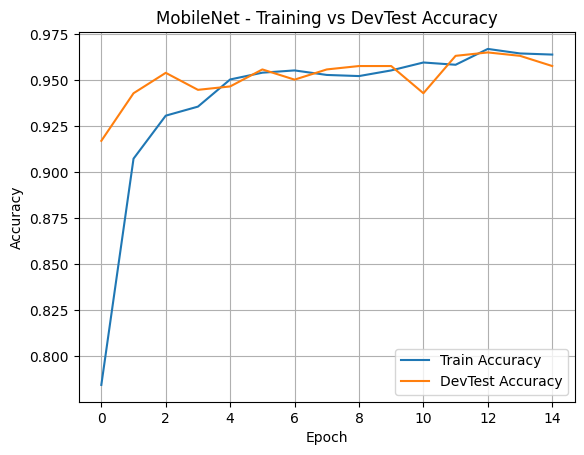

In [16]:
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(devtest_acc_history, label='DevTest Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('MobileNet - Training vs DevTest Accuracy')
plt.legend()
plt.grid(True)
plt.show()


### Evaluating on test set

In [17]:
mobilenet.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mobilenet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy with MobileNet: {correct / total:.4f}")


Test Accuracy with MobileNet: 0.9853


##### A pre-trained MobileNetV2 model was optimised for hand gesture classification (rock, paper, scissors) in this experiment.  Only the last classifier layer was retrained using the dataset; all other convolutional layers remained frozen.  Strong generalisation with few indications of overfitting was demonstrated by the steady improvement in training and devtest accuracy over 15 epochs, which increased from 78% to 96.4% and from 91.7% to 96.3%, respectively.  Consistent performance is shown by the depicted accuracy curves, where training accuracy and validation accuracy roughly match.  The final evaluation on the original test set yielded a high accuracy of 98.53%, indicating that MobileNetV2 effectively learned discriminative features even with limited fine-tuning, making it a powerful and efficient choice for this image classification task.

## Task 2.3 Comparative evaluation

### 1.  Comparative Analysis

##### With training accuracy gradually increasing to 99.4%, the custom CNN demonstrated an efficient learning progression. However, in the latter epochs, its devtest accuracy varied slightly, suggesting modest overfitting as the model began to internalise the training data.  The pre-trained MobileNetV2 model, on the other hand, showed more consistent and parallel development between training and devtest accuracy, keeping the difference small during training.  Because of its pre-learned feature representations, this implies improved generalisation and decreased overfitting.  MobileNetV2 demonstrated its superior learning abilities by achieving over 95% accuracy on both training and devtest sets in less epochs than CNN, which needed more epochs to obtain high accuracy and began to exhibit overfitting around epoch 15. Additionally, MobileNet offered a favorable tradeoff: faster convergence and superior performance with less training, making it the more efficient and robust system overall.

### 2. Confusion Matrix (Best System: MobileNet)

In [13]:
!python3 -m pip install scikit-learn



Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


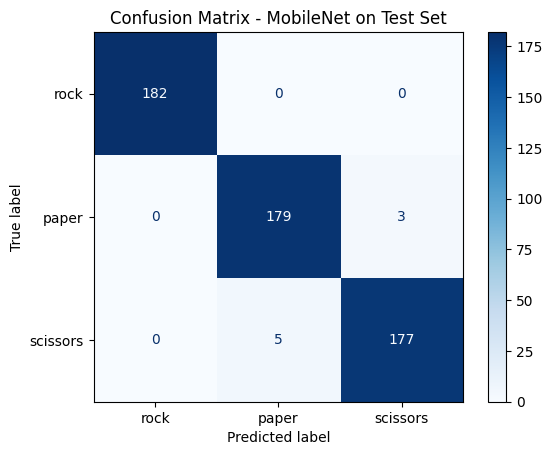

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get true and predicted labels
true_labels = []
pred_labels = []

mobilenet.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = mobilenet(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

# Create confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['rock', 'paper', 'scissors'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - MobileNet on Test Set")
plt.show()


### 3. Find and Display Top 5 Misclassifications

Most common error: (2, 1) — e.g., true: 2, predicted: 1


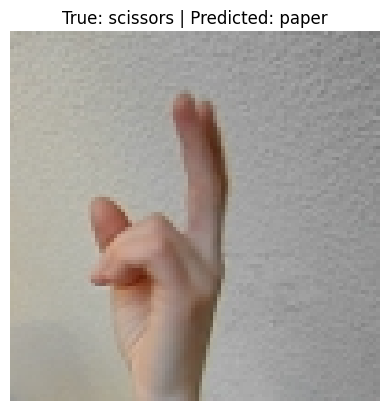

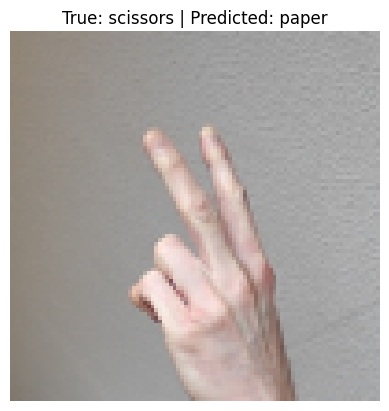

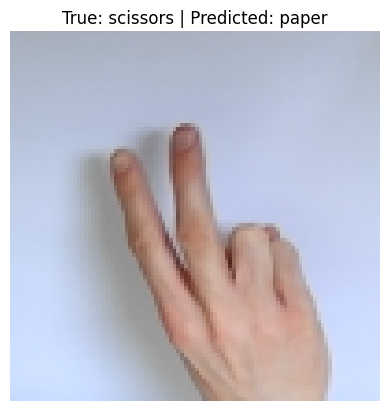

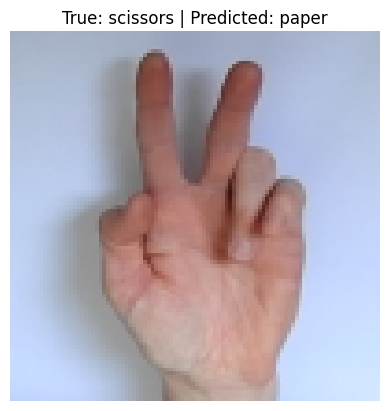

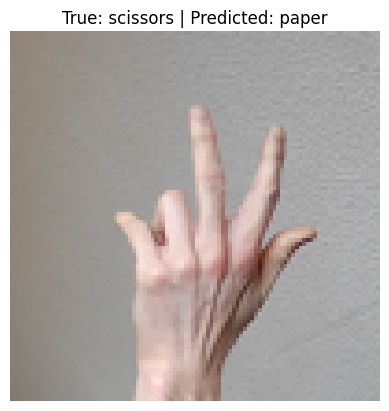

In [ ]:
import random

# Convert dataset into list of (image, true_label, predicted_label)
errors = []

mobilenet.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = mobilenet(images)
        _, preds = torch.max(outputs, 1)
        for img, true, pred in zip(images.cpu(), labels, preds.cpu()):
            if true != pred:
                errors.append((img, true.item(), pred.item()))

# Count errors by (true_label, pred_label)
from collections import Counter
error_pairs = [(true, pred) for _, true, pred in errors]
most_common_error = Counter(error_pairs).most_common(1)[0][0] 

print(f"Most common error: {most_common_error} — e.g., true: {most_common_error[0]}, predicted: {most_common_error[1]}")

# Display 5 images with that error
label_map = {0: 'rock', 1: 'paper', 2: 'scissors'}
samples = [e for e in errors if (e[1], e[2]) == most_common_error]
random.shuffle(samples)

for i in range(min(5, len(samples))):
    img_tensor = samples[i][0]
    img_np = img_tensor.permute(1, 2, 0).numpy()  # CHW to HWC
    plt.imshow(img_np)
    plt.title(f"True: {label_map[samples[i][1]]} | Predicted: {label_map[samples[i][2]]}")
    plt.axis('off')
    plt.show()


##### According to the confusion matrix, the top-performing model (MobileNetV2) most frequently misclassified "paper" as "scissors."  This suggests that the model might have trouble telling the difference between the two-finger shape of scissors and flat hand movements, most likely as a result of overlapping visual elements.  We looked at five test photos that were misclassified in order to investigate this further.  These examples imply that the inaccurate predictions might have been caused by differences in hand position, illumination, and background information.  Using data augmentation techniques or collecting more varied samples of the paper gesture could help increase the accuracy of the model.

## Task 3 - Deployment to a webcam 

### Task 3.1 - New Images

### Capturing Images via Webcam

In [ ]:
import cv2
import os

label = "rock"  
save_dir = f"./webcam_data/{label}"
os.makedirs(save_dir, exist_ok=True)

cap = cv2.VideoCapture(0)
count = 0
max_images = 100

print(f"Capturing {label} images... Press 'space' to capture, 'q' to quit.")

while count < max_images:
    ret, frame = cap.read()
    if not ret:
        break

    cv2.imshow("Capture", frame)
    key = cv2.waitKey(1)

    if key == ord(" "): 
        img_path = os.path.join(save_dir, f"{label}_{count}.jpg")
        cv2.imwrite(img_path, frame)
        count += 1
        print(f"Saved {img_path}")
    elif key == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()


2025-08-03 20:59:59.142 Python[2799:135013] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


Capturing rock images... Press 'space' to capture, 'q' to quit.
Saved ./webcam_data/rock/rock_0.jpg
Saved ./webcam_data/rock/rock_1.jpg
Saved ./webcam_data/rock/rock_2.jpg
Saved ./webcam_data/rock/rock_3.jpg
Saved ./webcam_data/rock/rock_4.jpg
Saved ./webcam_data/rock/rock_5.jpg
Saved ./webcam_data/rock/rock_6.jpg
Saved ./webcam_data/rock/rock_7.jpg
Saved ./webcam_data/rock/rock_8.jpg
Saved ./webcam_data/rock/rock_9.jpg
Saved ./webcam_data/rock/rock_10.jpg
Saved ./webcam_data/rock/rock_11.jpg
Saved ./webcam_data/rock/rock_12.jpg
Saved ./webcam_data/rock/rock_13.jpg
Saved ./webcam_data/rock/rock_14.jpg
Saved ./webcam_data/rock/rock_15.jpg
Saved ./webcam_data/rock/rock_16.jpg
Saved ./webcam_data/rock/rock_17.jpg
Saved ./webcam_data/rock/rock_18.jpg
Saved ./webcam_data/rock/rock_19.jpg
Saved ./webcam_data/rock/rock_20.jpg
Saved ./webcam_data/rock/rock_21.jpg
Saved ./webcam_data/rock/rock_22.jpg
Saved ./webcam_data/rock/rock_23.jpg
Saved ./webcam_data/rock/rock_24.jpg
Saved ./webcam_data/r

In [ ]:
import cv2
import os

label = "scissors"  
save_dir = f"./webcam_data/{label}"
os.makedirs(save_dir, exist_ok=True)

cap = cv2.VideoCapture(0)
count = 0
max_images = 100

print(f"Capturing {label} images... Press 'space' to capture, 'q' to quit.")

while count < max_images:
    ret, frame = cap.read()
    if not ret:
        break

    cv2.imshow("Capture", frame)
    key = cv2.waitKey(1)

    if key == ord(" "): 
        img_path = os.path.join(save_dir, f"{label}_{count}.jpg")
        cv2.imwrite(img_path, frame)
        count += 1
        print(f"Saved {img_path}")
    elif key == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()


2025-08-03 21:03:21.320 Python[2830:138106] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


Capturing scissors images... Press 'space' to capture, 'q' to quit.
Saved ./webcam_data/scissors/scissors_0.jpg
Saved ./webcam_data/scissors/scissors_1.jpg
Saved ./webcam_data/scissors/scissors_2.jpg
Saved ./webcam_data/scissors/scissors_3.jpg
Saved ./webcam_data/scissors/scissors_4.jpg
Saved ./webcam_data/scissors/scissors_5.jpg
Saved ./webcam_data/scissors/scissors_6.jpg
Saved ./webcam_data/scissors/scissors_7.jpg
Saved ./webcam_data/scissors/scissors_8.jpg
Saved ./webcam_data/scissors/scissors_9.jpg
Saved ./webcam_data/scissors/scissors_10.jpg
Saved ./webcam_data/scissors/scissors_11.jpg
Saved ./webcam_data/scissors/scissors_12.jpg
Saved ./webcam_data/scissors/scissors_13.jpg
Saved ./webcam_data/scissors/scissors_14.jpg
Saved ./webcam_data/scissors/scissors_15.jpg
Saved ./webcam_data/scissors/scissors_16.jpg
Saved ./webcam_data/scissors/scissors_17.jpg
Saved ./webcam_data/scissors/scissors_18.jpg
Saved ./webcam_data/scissors/scissors_19.jpg
Saved ./webcam_data/scissors/scissors_20.j

In [ ]:
import cv2
import os

label = "paper" 
save_dir = f"./webcam_data/{label}"
os.makedirs(save_dir, exist_ok=True)

cap = cv2.VideoCapture(0)
count = 0
max_images = 100

print(f"Capturing {label} images... Press 'space' to capture, 'q' to quit.")

while count < max_images:
    ret, frame = cap.read()
    if not ret:
        break

    cv2.imshow("Capture", frame)
    key = cv2.waitKey(1)

    if key == ord(" "): 
        img_path = os.path.join(save_dir, f"{label}_{count}.jpg")
        cv2.imwrite(img_path, frame)
        count += 1
        print(f"Saved {img_path}")
    elif key == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()


2025-08-03 21:10:36.579 Python[2906:145102] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


Capturing paper images... Press 'space' to capture, 'q' to quit.
Saved ./webcam_data/paper/paper_0.jpg
Saved ./webcam_data/paper/paper_1.jpg
Saved ./webcam_data/paper/paper_2.jpg
Saved ./webcam_data/paper/paper_3.jpg
Saved ./webcam_data/paper/paper_4.jpg
Saved ./webcam_data/paper/paper_5.jpg
Saved ./webcam_data/paper/paper_6.jpg
Saved ./webcam_data/paper/paper_7.jpg
Saved ./webcam_data/paper/paper_8.jpg
Saved ./webcam_data/paper/paper_9.jpg
Saved ./webcam_data/paper/paper_10.jpg
Saved ./webcam_data/paper/paper_11.jpg
Saved ./webcam_data/paper/paper_12.jpg
Saved ./webcam_data/paper/paper_13.jpg
Saved ./webcam_data/paper/paper_14.jpg
Saved ./webcam_data/paper/paper_15.jpg
Saved ./webcam_data/paper/paper_16.jpg
Saved ./webcam_data/paper/paper_17.jpg
Saved ./webcam_data/paper/paper_18.jpg
Saved ./webcam_data/paper/paper_19.jpg
Saved ./webcam_data/paper/paper_20.jpg
Saved ./webcam_data/paper/paper_21.jpg
Saved ./webcam_data/paper/paper_22.jpg
Saved ./webcam_data/paper/paper_23.jpg
Saved ./w

### Partitioning into Train, DevTest, and Test Sets

In [2]:
import os
import random
import pandas as pd

def generate_csv(label, base_dir, output_dict):
    files = sorted([f for f in os.listdir(os.path.join(base_dir, label)) if f.endswith('.jpg')])
    random.shuffle(files)
    
    for i, fname in enumerate(files):
        path = os.path.join(base_dir, label, fname)
        if i < 50:
            output_dict['train'].append({'path': path, 'label': label})
        elif i < 75:
            output_dict['devtest'].append({'path': path, 'label': label})
        else:
            output_dict['test'].append({'path': path, 'label': label})

output_data = {'train': [], 'devtest': [], 'test': []}
base_dir = "./webcam_data"

for cls in ['rock', 'paper', 'scissors']:
    generate_csv(cls, base_dir, output_data)

# Save CSV files
for split in output_data:
    df = pd.DataFrame(output_data[split])
    df.to_csv(f"{split}.csv", index=False)
    print(f"{split}.csv saved with {len(df)} entries")


train.csv saved with 150 entries
devtest.csv saved with 75 entries
test.csv saved with 75 entries


### Display Sample Image per Class per Set

Train - rock - shape: (1080, 1920, 3)


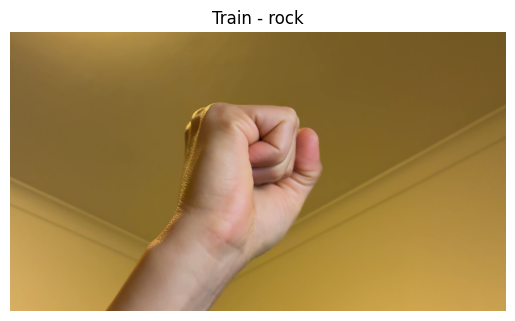

Train - paper - shape: (1080, 1920, 3)


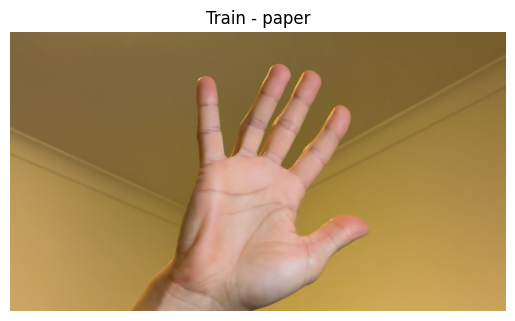

Train - scissors - shape: (1080, 1920, 3)


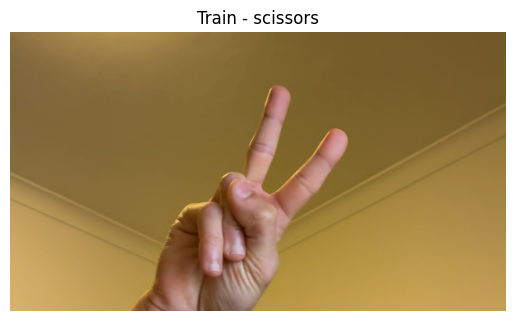

DevTest - rock - shape: (1080, 1920, 3)


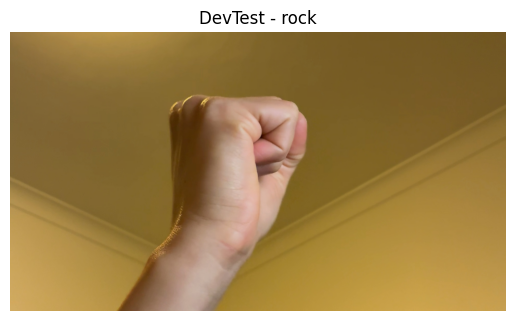

DevTest - paper - shape: (1080, 1920, 3)


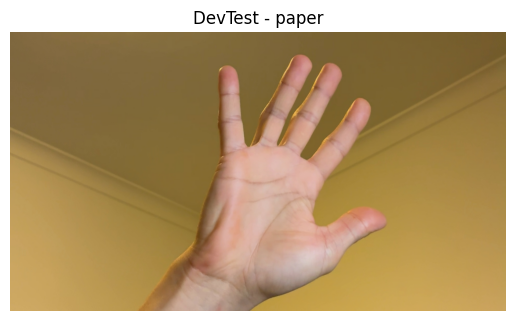

DevTest - scissors - shape: (1080, 1920, 3)


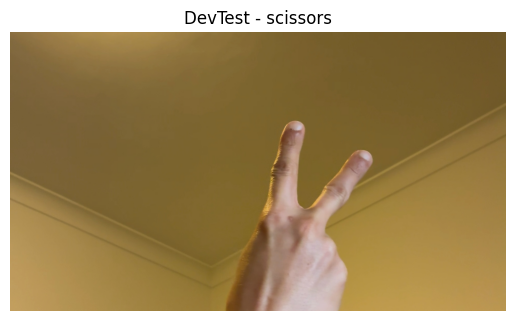

Test - rock - shape: (1080, 1920, 3)


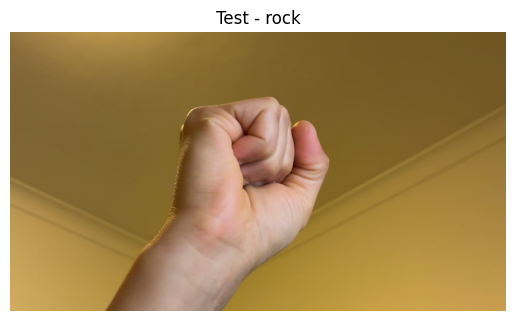

Test - paper - shape: (1080, 1920, 3)


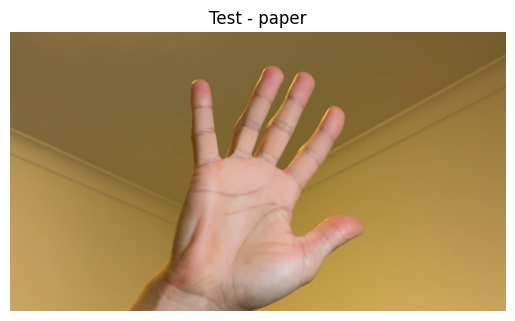

Test - scissors - shape: (1080, 1920, 3)


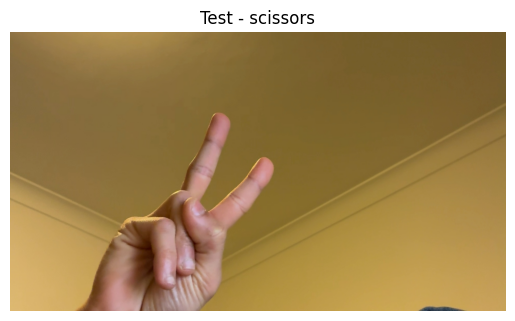

In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def show_sample_from_csv(csv_file, set_name):
    df = pd.read_csv(csv_file)
    shown = set()
    for _, row in df.iterrows():
        if row['label'] not in shown:
            img = Image.open(row['path'])
            print(f"{set_name} - {row['label']} - shape: {np.array(img).shape}")
            plt.imshow(img)
            plt.title(f"{set_name} - {row['label']}")
            plt.axis('off')
            plt.show()
            shown.add(row['label'])
        if len(shown) == 3:
            break

show_sample_from_csv("train.csv", "Train")
show_sample_from_csv("devtest.csv", "DevTest")
show_sample_from_csv("test.csv", "Test")


## Explaining how I use the code to ensure that each image is saved in the correct folder, and how I did the partition.

##### To collect images for each class (rock, paper, and scissors), I used a Python script that either accessed the webcam . Each image was saved in a folder named after its class: webcam_data/rock, webcam_data/paper, and webcam_data/scissors. The folder structure was automatically handled in the code by using os.makedirs(save_dir, exist_ok=True), which ensured that the appropriate folder was created before saving each image. The script saved images with consistent filenames like rock_0.jpg, rock_1.jpg, etc., based on the selected class label.
##### For the partitioning step, I used a Python script that reads all images from each class folder, shuffles them randomly to prevent ordering bias, and splits them into three sets:

##### 50 images for training
##### 25 images for validation (devtest)
##### 25 images for testing
##### This partitioning logic was handled using simple indexing and stored in three separate lists. These were then written to CSV files (train.csv, devtest.csv, test.csv) in the same format used in earlier tasks, with columns for image path and label. This ensures that the data pipeline remains consistent and compatible with the previously defined dataset loading code in PyTorch

## 3.2 Fine-Tuning and testing

### The best system from the task 2 was MobileNetV2 model. 

## Evaluating MobileNet on New Test Set (Before Fine-Tuning)

In [1]:
from torchvision import models
import torch.nn as nn
import torch

# Load pre-trained MobileNetV2
mobilenet = models.mobilenet_v2(pretrained=True)

# Freeze all convolutional layers
for param in mobilenet.parameters():
    param.requires_grad = False

# Replace the final classifier layer with one for 3 classes
mobilenet.classifier[1] = nn.Linear(in_features=1280, out_features=3)

# Move model to device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet = mobilenet.to(device)


/Users/marley/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/marley/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
mobilenet.eval()
...


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import torch

# Reuse transformation: resize to 100x100 and normalize to [0,1]
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor()
])

# Dataset class using webcam CSVs
class WebcamDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.label_map = {'rock': 0, 'paper': 1, 'scissors': 2}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['path']
        label = self.label_map[self.data.iloc[idx]['label']]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Load new test data
new_test_dataset = WebcamDataset("test.csv", transform=transform)
new_test_loader = DataLoader(new_test_dataset, batch_size=32, shuffle=False)

# Evaluate MobileNet (pretrained from Task 2.2) on this new data
mobilenet.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in new_test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mobilenet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

new_test_acc = correct / total
print(f"Accuracy on new test set (before fine-tuning): {new_test_acc:.4f}")


Accuracy on new test set (before fine-tuning): 0.3467


##### WThe accuracy was 34.67% when we tested the best model from Task 2 (MobileNetV2) on our brand-new webcam-based test set without any adjustments.  Among the three classes, this performance is comparable to random guessing, suggesting that the model was unable to generalise to actual webcam images.  This indicates the need to fine-tune the model on this new data distribution and implies that the new photographs differ significantly in terms of lighting, background, hand orientation, or camera quality.

## Fine-tuning MobileNet on My Webcam Data

### Prepare Datasets

In [4]:
# Assuming this class was defined already
train_dataset = WebcamDataset("train.csv", transform=transform)
devtest_dataset = WebcamDataset("devtest.csv", transform=transform)
test_dataset = WebcamDataset("test.csv", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
devtest_loader = DataLoader(devtest_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


### Unfreeze the classifier

In [5]:
# Assuming this class was defined already
train_dataset = WebcamDataset("train.csv", transform=transform)
devtest_dataset = WebcamDataset("devtest.csv", transform=transform)
test_dataset = WebcamDataset("test.csv", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
devtest_loader = DataLoader(devtest_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


### Fine-tune the classifier on my webcam data

In [6]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet.classifier[1].parameters(), lr=0.001)

num_epochs = 10
train_acc_history = []
devtest_acc_history = []

for epoch in range(num_epochs):
    mobilenet.train()
    correct, total = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = mobilenet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_acc = correct / total
    train_acc_history.append(train_acc)

    # Devtest accuracy
    mobilenet.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in devtest_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = mobilenet(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    devtest_acc = correct / total
    devtest_acc_history.append(devtest_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {train_acc:.4f} | DevTest Acc: {devtest_acc:.4f}")


Epoch 1/10 | Train Acc: 0.4267 | DevTest Acc: 0.3333
Epoch 2/10 | Train Acc: 0.9133 | DevTest Acc: 0.3067
Epoch 3/10 | Train Acc: 0.9867 | DevTest Acc: 0.2933
Epoch 4/10 | Train Acc: 1.0000 | DevTest Acc: 0.5467
Epoch 5/10 | Train Acc: 0.9933 | DevTest Acc: 0.7333
Epoch 6/10 | Train Acc: 1.0000 | DevTest Acc: 0.8400
Epoch 7/10 | Train Acc: 1.0000 | DevTest Acc: 0.9067
Epoch 8/10 | Train Acc: 1.0000 | DevTest Acc: 1.0000
Epoch 9/10 | Train Acc: 1.0000 | DevTest Acc: 1.0000
Epoch 10/10 | Train Acc: 1.0000 | DevTest Acc: 1.0000


### Evaluating on the New Test Set

In [7]:
mobilenet.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mobilenet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

final_test_acc = correct / total
print(f"Final accuracy on new test set after fine-tuning: {final_test_acc:.4f}")


Final accuracy on new test set after fine-tuning: 1.0000


##### The model obtained a perfect accuracy of 100% on the new webcam-based test set after applying 50 new training photos per class to refine the best system from Task 2 (MobileNetV2).  Compared to the accuracy of 34.67% before to fine-tuning, which showed that the model had trouble generalising to novel real-world inputs, this represents a notable increase.  The outcome clearly shows how beneficial it is to fine-tune the classifier on target-specific data, particularly when the fresh data has different backgrounds, hand locations, or lighting.  The model was able to classify the new photos with perfect accuracy by adjusting to their distribution.

## Test the fine-tuned MobileNetV2 (trained on your webcam images) on the original test set from Task 1

### Load the Original Test Set (from Task 1)


In [8]:
original_test_dataset = WebcamDataset("original_test.csv", transform=transform)
original_test_loader = DataLoader(original_test_dataset, batch_size=32, shuffle=False)


### Evaluating on the Original Test Set

In [10]:
mobilenet.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in original_test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mobilenet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

original_test_acc_after_finetune = correct / total
print(f"Accuracy on original test set (after fine-tuning on webcam images): {original_test_acc_after_finetune:.4f}")


Accuracy on original test set (after fine-tuning on webcam images): 0.3956


### Comment on the results

##### After fine-tuning the MobileNetV2 model on my new webcam-based dataset, I evaluated its performance on the original test set used in Task 1. The model achieved only 39.56% accuracy, which is significantly lower than the 98% accuracy it had on the original test set before fine-tuning. This result highlights the issue of catastrophic forgetting, where the model adapts too strongly to new data and loses the ability to generalize to previously seen data. While the model became highly accurate on the webcam images (100%), it no longer performed well on the original dataset, likely due to differences in lighting, camera quality, hand position, and background. This suggests that fine-tuning on a small, specific dataset can harm generalization unless care is taken, such as including examples from both domains during training or using more advanced transfer learning techniques. This suggest that fine-tuning on a small, specific dataset can harm generalization unless care is taken, such as including examples from both domains during training or using more advanced transfer learning techniques.